# Loading data with polars from postgres database

In [4]:
import polars as pl
import psycopg2

In [7]:
conn = psycopg2.connect(
    dbname="handson",
    user="postgres",
    password="postgres",
    host="localhost",
)

mnist = pl.read_database(
    query="SELECT id, label, pixels from mnist",
    connection=conn,
)

In [8]:
mnist.head()

id,label,pixels
i64,i64,list[f64]
1,0,"[0.0, 0.0, … 0.0]"
2,7,"[0.0, 0.0, … 0.0]"
3,1,"[0.0, 0.0, … 0.0]"
4,1,"[0.0, 0.0, … 0.0]"
5,4,"[0.0, 0.0, … 0.0]"


In [11]:
mnist[0, -1].shape

(784,)

In [20]:
X = mnist.select(pl.col('pixels'))
y = mnist.select(pl.col('label'))

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [52]:
some_digit = X.item(0, 'pixels')
some_label = y.item(0, 'label')

some_digit_image = some_digit.to_numpy().reshape((28,28))

In [163]:
some_five = mnist.filter(
    pl.col('label') == 5
).item(0, 'pixels')

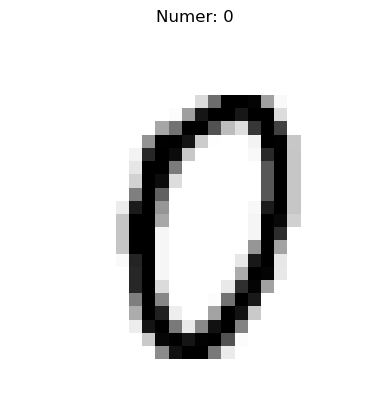

In [58]:
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation="nearest")
plt.axis('off')
plt.title(f"Numer: {some_label}")
plt.show()

In [60]:
y = y.select(pl.col('label').cast(pl.Int8))

In [251]:
X_train = X[:60000, :]
y_train = y[:60000, :]
X_test = X[60000:, :]
y_test = y[60000:, :]

In [80]:
y_train_dig_proportion = y_train.select(
    pl.col('label').value_counts(normalize=True)
).unnest('label').sort('label')
y_test_dig_proportion = y_test.select(
    pl.col('label').value_counts(normalize=True)
).unnest('label').sort('label')

In [72]:
import seaborn as sns

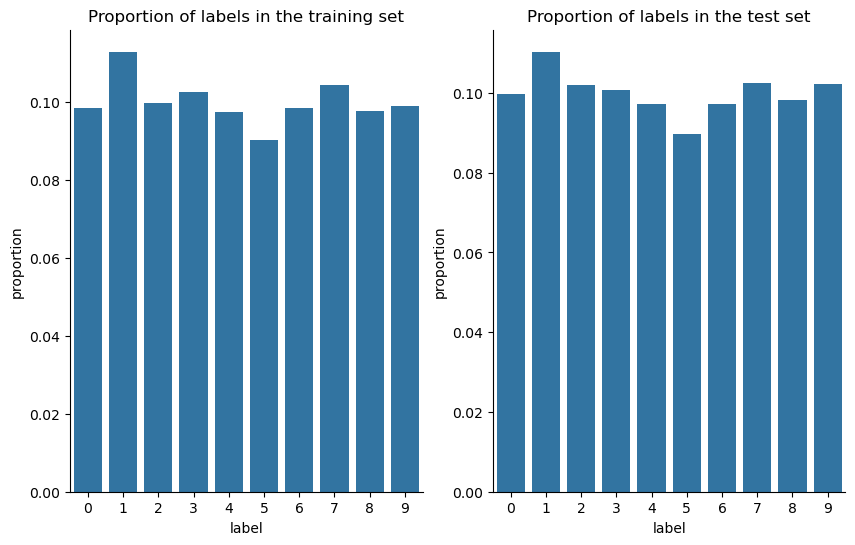

In [90]:
fig, axes = plt.subplots(1,2,figsize=(10, 6))
sns.barplot(x=y_train_dig_proportion['label'], y=y_train_dig_proportion['proportion'], ax=axes[0])
axes[0].set_title('Proportion of labels in the training set')
sns.barplot(x=y_test_dig_proportion['label'], y=y_test_dig_proportion['proportion'], ax=axes[1])
axes[1].set_title('Proportion of labels in the test set')
sns.despine()

## The 5 detector

In [131]:
import numpy as np

In [254]:
y_train_5 = y_train.select(pl.col('label') == 5)
y_test_5 = y_test.select(pl.col('label') == 5)

In [148]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_array, y_train_5)

/opt/homebrew/Caskroom/miniforge/base/envs/handson/lib/python3.14/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


### Manual CV

In [257]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

X_train_numpy = np.array(X_train['pixels'].to_list())
y_train_5_numpy = np.array(y_train_5['label'].to_list()).ravel()

# assuming we're dealing with Polars Dataframes
for i, (train_index, test_index) in enumerate(skfolds.split(X_train_numpy, y_train_5_numpy), 1):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train_numpy[train_index]
    y_train_5_folds = y_train_5_numpy[train_index]
    X_test_folds = X_train_numpy[test_index]
    y_test_5_folds = y_train_5_numpy[test_index]

    clone_clf.fit(X_train_folds, y_train_5_folds)
    y_pred = clone_clf.predict(X_test_folds)
    accuracy = np.mean(y_test_5_folds == y_pred)
    print(f"Accuracy of fold {i}: {accuracy:.4f}")

Accuracy of fold 1: 0.9686
Accuracy of fold 2: 0.9315
Accuracy of fold 3: 0.9610


### CV built-in

In [258]:
from sklearn.model_selection import cross_val_score

sgd_cv_score = cross_val_score(sgd_clf, X_train_numpy, y_train_5_numpy, cv=3, scoring='accuracy')
print(sgd_cv_score)

[0.9686 0.9315 0.961 ]


### Dumb Classfier

In [259]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [262]:
dumb_clf = Never5Classifier()
y_pred_5_dumb = dumb_clf.predict(X_train_numpy)
cv_dumb = cross_val_score(dumb_clf, X_train_numpy, y_train_5_numpy, cv=3, scoring='accuracy')
print(cv_dumb)

[0.91205 0.90815 0.90915]


### Confussion Matrix

In [263]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cv_y_train_pred = cross_val_predict(sgd_clf, X_train_numpy, y_train_5_numpy, n_jobs=-1, cv=3)
sgd_confussion_matrix = confusion_matrix(y_train_5_numpy, cv_y_train_pred)

In [264]:
print(sgd_confussion_matrix)

[[52853  1734]
 [ 1044  4369]]


<Axes: >

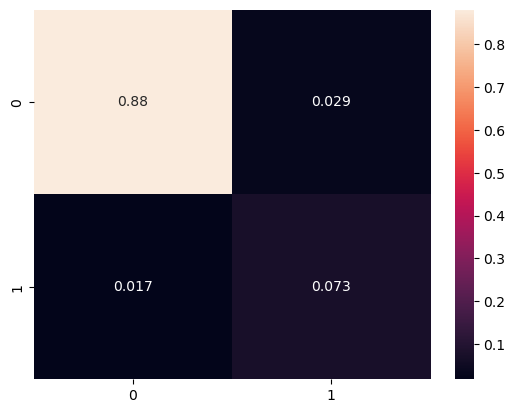

In [266]:
sns.heatmap(sgd_confussion_matrix/len(X_train_numpy), annot=True)